# Oil Seep Detection 

In [1]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import *
from keras.callbacks import *

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
import cv2
import os

Using TensorFlow backend.


In [2]:
tf.test.is_gpu_available()

True

## Explore Dataset

In [0]:
def plot_image_mask(img, mask):
    fig, ax = plt.subplots(1,2, figsize=(12,8))
    
    ax[0].imshow(img, cmap="gray")
    ax[0].set_title("Seep Image")

    ax[1].imshow(mask)
    ax[1].set_title("Mask")

    plt.show()

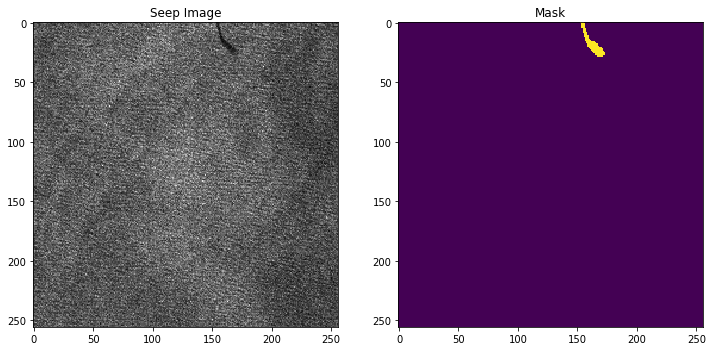

In [4]:
idx = 1

img_path = "seep_detection/images/train_images_256/"
mask_path = "seep_detection/masks/train_masks_256/"

images = []
masks = []

for filename in os.listdir(img_path):
    images.append((plt.imread(img_path + filename)))
    masks.append(plt.imread(mask_path + filename))

plot_image_mask(images[idx], masks[idx])

In [5]:
print("Dataset Size: {}".format(len(images)))

Dataset Size: 790


## Preprocess Data 

In [6]:
images_process = np.expand_dims(images, -1) / 255
masks_onehot = np.expand_dims(masks, -1) 

X_train, X_test, y_train, y_test = train_test_split(images_process, masks_onehot, test_size=0.2, random_state=1)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

print("Training Samples: {}".format(len(y_train)))
print("Validation Samples: {}".format(len(y_val)))
print("Testing Samples: {}".format(len(y_test)))

Training Samples: 632
Validation Samples: 79
Testing Samples: 79


In [0]:
batch_size = 32

# we create two instances with the same arguments
data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     fill_mode='constant',
                     cval=0,)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(
    X_train, 
    batch_size=batch_size,
    shuffle=True,
    seed=seed)

mask_generator = mask_datagen.flow(
    y_train, 
    batch_size=batch_size,
    shuffle=True,
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

## Validate Preprocessing

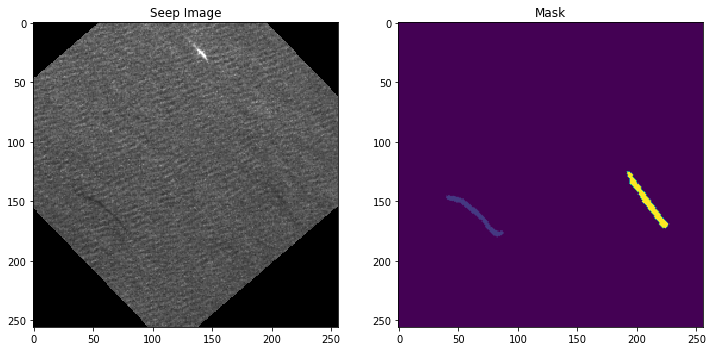

In [8]:
for img, mask in train_generator:
    mask_test = mask[0][:,:,0]
    img_test = img[0][:,:,0]
    break

plot_image_mask(img_test, mask_test)

## Modeling

In [9]:
from losses import *
from models import *


N_CLASSES = 8  
CLASS_WEIGHTS = [0.1, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.15]


def weighted_binary_crossentropy(y_true, y_pred):
    class_loglosses = K.mean(K.binary_crossentropy(y_true, y_pred), axis=[0, 1, 2])
    return K.sum(class_loglosses * K.constant(CLASS_WEIGHTS))

# model = get_unet()
model = unet_model(
    n_classes=N_CLASSES, im_sz=256, n_channels=1, class_weights=CLASS_WEIGHTS)

model.compile(optimizer=Adam(lr=0.0001), loss=weighted_binary_crossentropy, metrics=['acc'])

# model.compile(
#     optimizer=Adam(lr=0.001), 
#     loss=weighted_cross_entropy(0.3), 
#     metrics=['acc'])

# model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Training

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train)//batch_size,
    validation_data=(X_val, y_val),
    validation_steps=100,
    callbacks=[early_stopping],
    epochs=100)



Epoch 1/100
19/19 [==============================] - 61s 3s/step - loss: 2.1358 - acc: 0.0064 - val_loss: 1.1300 - val_acc: 0.0033
Epoch 2/100
19/19 [==============================] - 34s 2s/step - loss: 0.7180 - acc: 0.0084 - val_loss: 0.4276 - val_acc: 0.0015
Epoch 3/100
19/19 [==============================] - 30s 2s/step - loss: 0.3496 - acc: 0.0019 - val_loss: 0.2799 - val_acc: 3.6061e-04
Epoch 4/100
19/19 [==============================] - 30s 2s/step - loss: 0.2628 - acc: 3.0622e-04 - val_loss: 0.2200 - val_acc: 1.7190e-05
Epoch 5/100
19/19 [==============================] - 30s 2s/step - loss: 0.1906 - acc: 5.0584e-05 - val_loss: 0.2005 - val_acc: 1.2748e-05
Epoch 6/100
19/19 [==============================] - 30s 2s/step - loss: 0.1845 - acc: 9.4112e-06 - val_loss: 0.1927 - val_acc: 1.1782e-05
Epoch 7/100
19/19 [==============================] - 30s 2s/step - loss: 0.1599 - acc: 1.0214e-05 - val_loss: 0.1823 - val_acc: 1.6611e-05
Epoch 8/100
19/19 [==========================

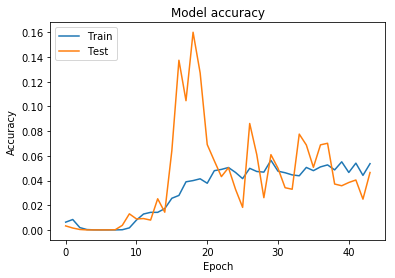

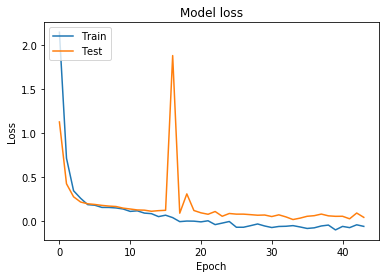

In [11]:
# # Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()




Sample 1


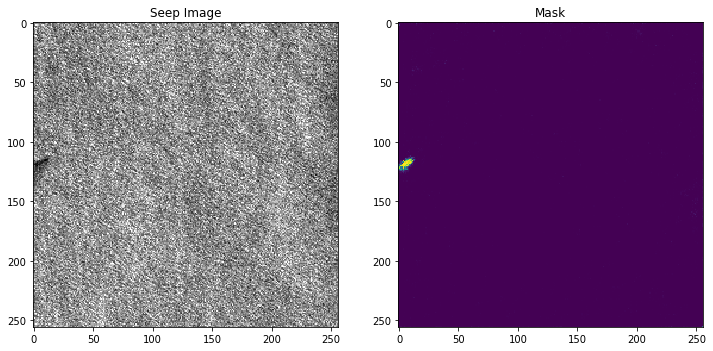

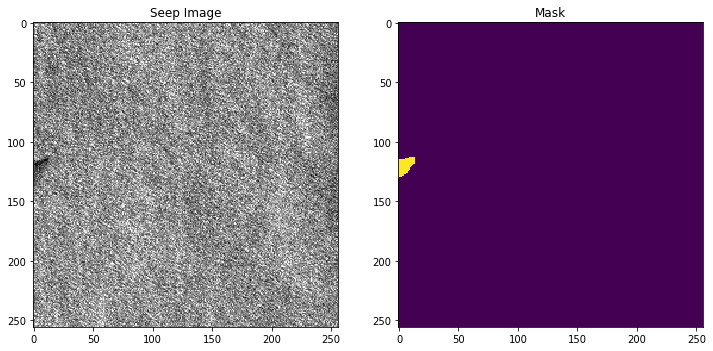




Sample 2


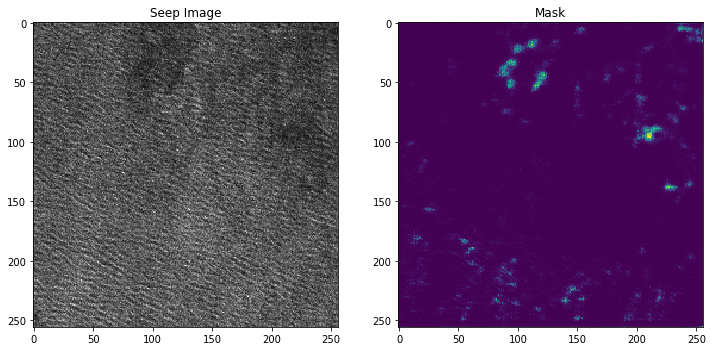

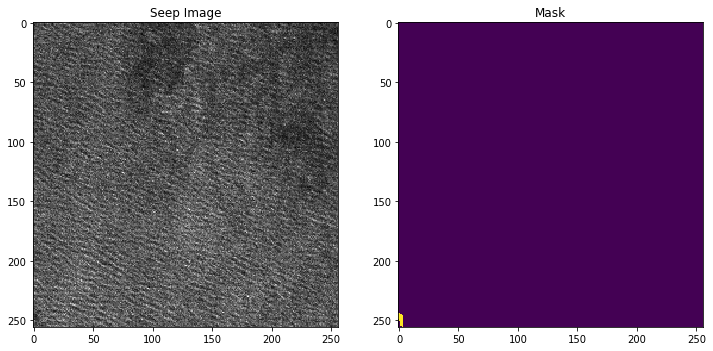




Sample 3


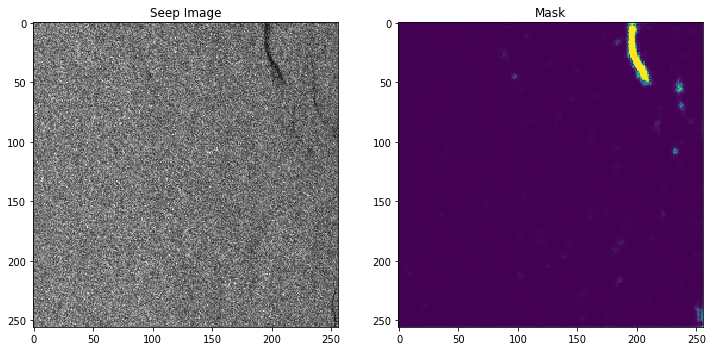

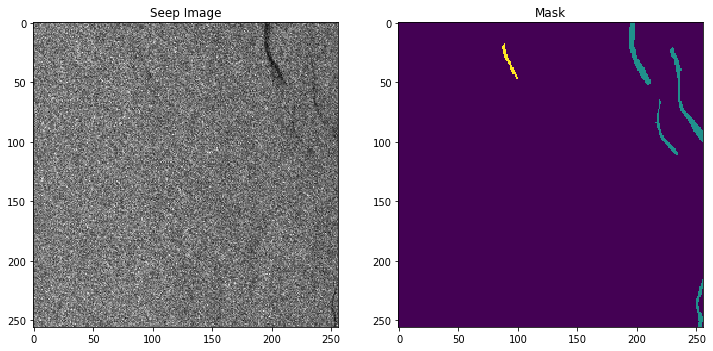




Sample 4


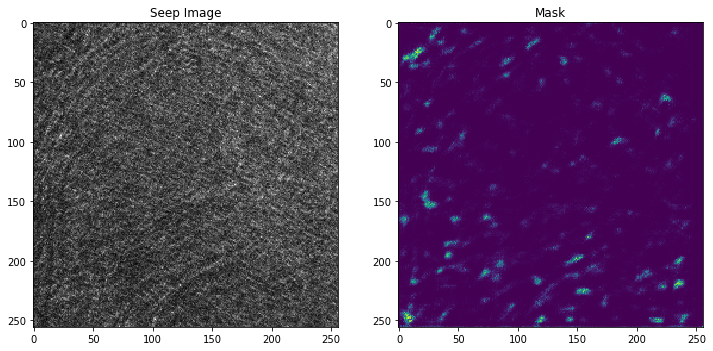

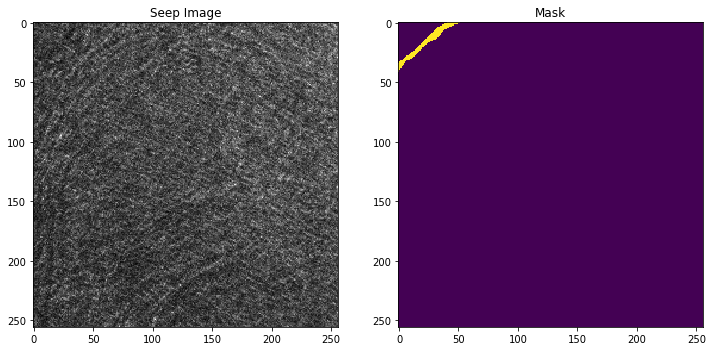




Sample 5


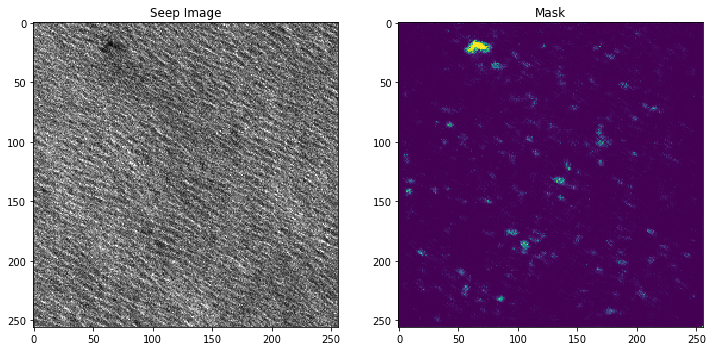

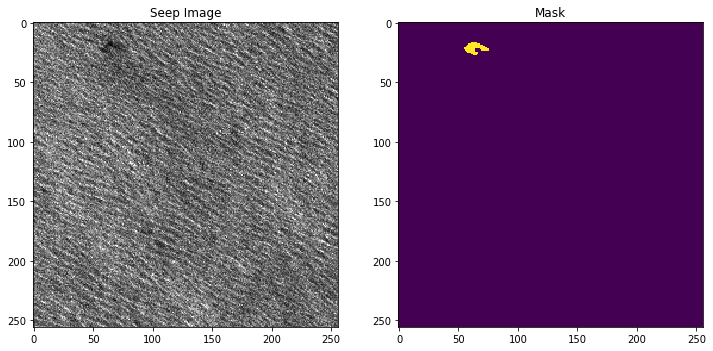




Sample 6


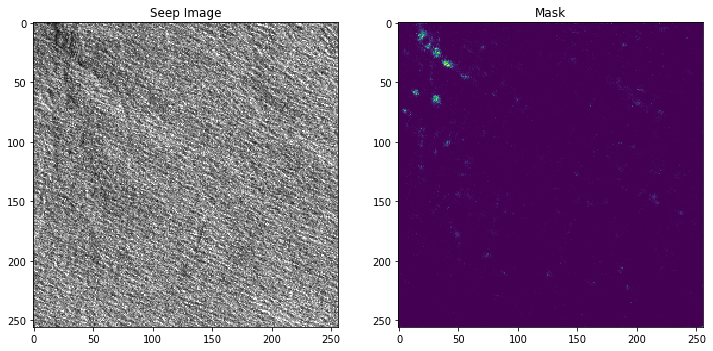

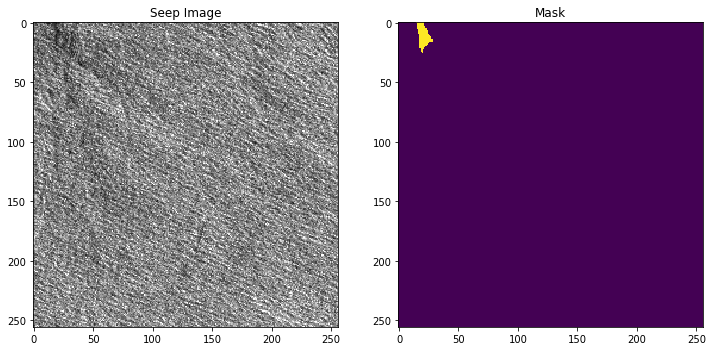




Sample 7


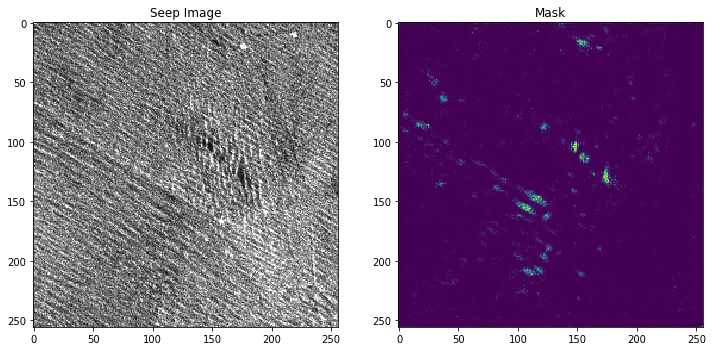

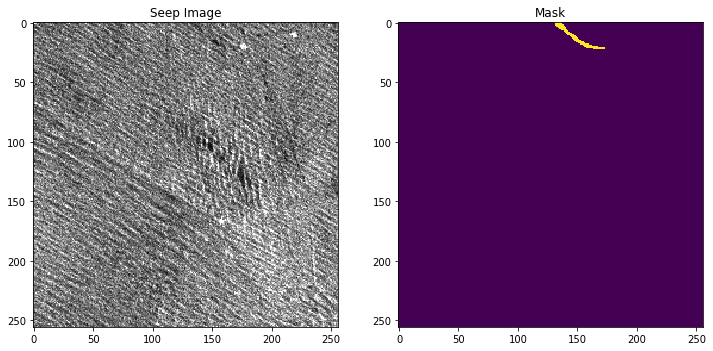




Sample 8


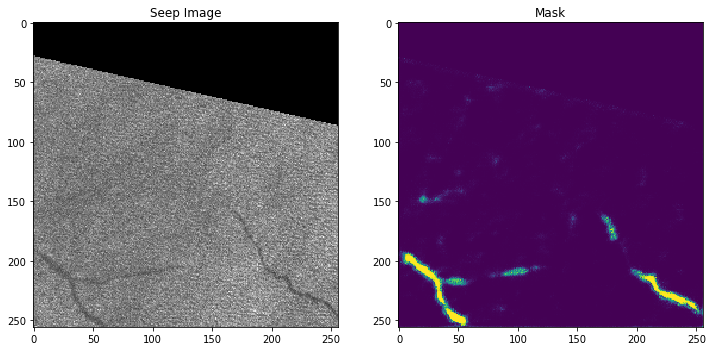

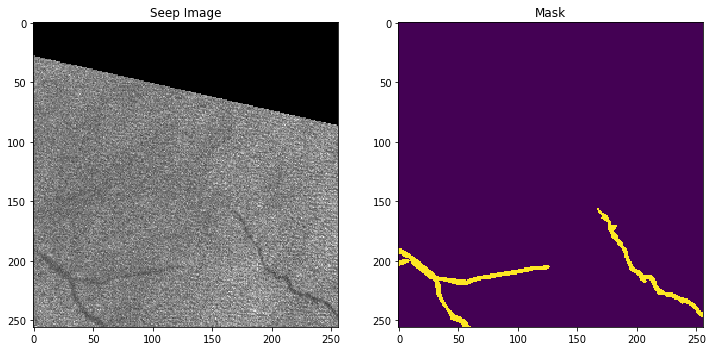




Sample 9


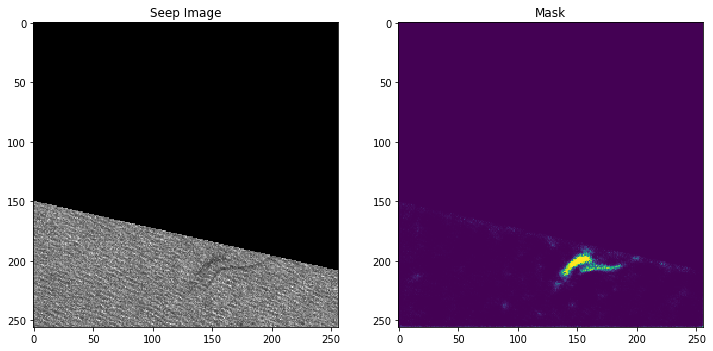

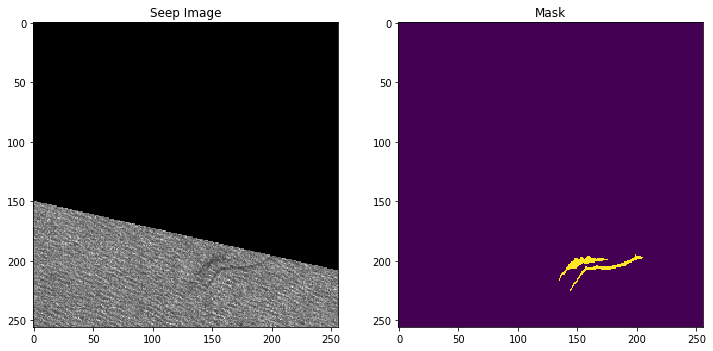

In [15]:
preds = model.predict(X_test)

for idx in range(1,10):
  print("\n\n\nSample {}".format(idx))
  plot_image_mask(X_test[idx][:,:,0], preds[idx][:,:,0])
  plot_image_mask(X_test[idx][:,:,0], y_test[idx][:,:,0])